# Tipping Module Calibration
---
**Author** : Amaury Laridon

**Date** : 28/10/23

---

## Algorithme I with parameterization choice A for the fresh water flux

Here, we will numerically translate Algorithm I, which corresponds to the method described in [[Note de Travail - Cadre mathématique coefficients de couplage]] and which is a generalized application of Monteiro's (2022) method. We first look at the simplest choice of parameterization, i.e. choice "A" for the freshwater flow with a single forcing parameter.

### AMOC's calibration

#### Reminder of the mathematical framework
We wish to calibrate the following ODE
$$   \frac{d\Psi}{dt} = -\Psi^3 + a_1\Psi^2 + b_1\Psi + c_1 + d_1 T + e_{12} F_{GIS}
\quad (9)   $$
The mathematical framework described in [[Note de Travail - Cadre mathématique coefficients de couplage]] has given us the following results for coefficient values,

$$a_1 = \frac{3(\Psi^{-}+\Psi^{+})}{2} \quad (1) $$
$$b_1 =  -3 \Psi^{-}\Psi^+ \quad (2)$$
$$  c_1^A  = \frac{T^+_\Psi\Psi^{-^{2}}(\Psi^{-}-3\Psi^+)-T^{-}_\Psi\Psi^{+^{2}}(\Psi^{+}-3\Psi^{-})}{2(T^{-}_\Psi-T^{+}_\Psi)} \quad (3) $$
$$  d_1 = -\frac{(\Psi^{+}-\Psi^{-})^3}{2(T^{+}_\Psi-T^{-}_\Psi)} \quad (4)   $$
$$ c_1^B  = \frac{F_{GIS}^+\Psi^{-^{2}}(\Psi^{-}-3\Psi^+)-F_{GIS}^{-}\Psi^{+^{2}}(\Psi^{+}-3\Psi^{-})}{2(F_{GIS}^{-}-F_{GIS}^{+})} \quad (5) $$
$$  e_{12} =-\frac{(\Psi^{+}-\Psi^{-})^3}{2(F_{GIS}^{+}-F_{GIS}^{-})} \quad (6) $$
$$ c_1 = c_1^A - e_{12}F_{GIS}^A \quad (7) $$
$$c_1 = c_1^B - d_1T_{\Psi}^B \quad (8) $$

For the experience noted A which represents the sensibility experiment with regard to temperature anomaly and a fixed fresh water flux we have,

$$  \frac{d\Psi}{dt} = -\Psi^3 + a_1\Psi^2 + b_1\Psi + c_1^A + d_1 T  \quad (9)  $$

For the experience noted B which represents the sensibility experiment with regard to fresh water flux and a fixed temperature anomaly we have,

$$  \frac{d\Psi}{dt} = -\Psi^3 + a_1\Psi^2 + b_1\Psi + c_1^B + e_{12} F_{GIS}  \quad (10)  $$ 

#### Numerical implementation

First, we want to make a numerical implementation of this mathematical framework and test it by giving as input any critical values of the bifurcation coordinates. In other words, we're first going to see whether, given the data we want to reproduce, the algorithm is a good fit before, in a second phase, providing the algorithm with real experimental values as input.

##### Libraries import 

In [95]:
import matplotlib.pyplot as plt
import numpy as np

##### Calibration module 

The critical values of the system variable under study (AMOC or GIS) are generally denoted by $xp, xm$, corresponding to the upper and lower critical values respectively. The critical values of the forcings are noted $op, om$. 

To avoid confusion, I explicitly define a function by coefficients, although the form is the same for many coefficients and I can simply change the arguments of the common function when calling the function and assigning it to the coefficient.

In [96]:
### Definition of the functions computing the coefficient's values. 
def a1(xp,xm):
    """Definition of the a_1 coefficient cfr. Eq.(1)"""
    return (3/2)*(xp+xm)
def b1(xp,xm):
    """Definition of the b_1 coefficient cfr. Eq.(2)"""
    return -3*xp*xm
def c1_A(xp,xm,op,om):
    """Definition of the c_1^A coefficient cfr. Eq.(3)"""
    return (op*xm**2*(xm-3*xp)-om*xp**2*(xp-3*xm))/(2*(om-op))
def d1(xp,xm,op,om):
    """Definition of the d_1 coefficient cfr. Eq.(4)"""
    return -(xp-xm)**3/(2*(op-om))
def c1_B(xp,xm,op,om):
    """Definition of the c_1^B coefficient cfr. Eq.(5)"""
    return (op*xm**2*(xm-3*xp)-om*xp**2*(xp-3*xm))/(2*(om-op))
def e12(xp,xm,op,om):
    """Definition of the c_12 coefficient cfr. Eq.(6)"""
    return -(xp-xm)**3/(2*(op-om))
def c1_from_A(c1_A, e12, F_A):
    """Definition of the c_1 coefficient from experience A cfr. Eq.(7)"""
    return c1_A-(e12*F_A)
def c1_from_B(c1_B, e12, T_B):
    """Definition of the c_1 coefficient from experience B cfr. Eq.(8)"""
    return c1_B-(e12*T_B)
### Definition of the calibration module ###
def calib_module_AMOC_ParamA(psip,psim, Tp, Tm, Fp, Fm, F_A, T_B):
    """Calibration module for the AMOC with the parametrisation A for the fresh water flux."""
    a_1 = a1(psip, psim)
    b_1 = b1(psip,psim)
    c1A = c1_A(psip, psim, Tp, Tm)
    d_1 = d1(psip,psim, Tp, Tm)
    c1B = c1_B(psip, psim, Fp, Fm)
    e_12 = e12(psip, psim, Fp, Fm)
    c1_f_A = c1_from_A(c1A, e_12, F_A)
    c1_f_B = c1_from_B(c1B, d_1, T_B)
    return [a_1, b_1, c1A, d_1, c1B, e_12, c1_f_A, c1_f_B]


##### Test data

In [97]:
psip = 1
psim = 0.1
Tp = 3
Tm = 1.2
Fp = 0.5
Fm = 0.05
F_A = 0.1
T_B = 2

##### Algorithm's test

In [98]:
### Calibrated emulation ###

calibrate_coef = calib_module_AMOC_ParamA(psip, psim, Tp, Tm, Fp, Fm, F_A, T_B)
#print(calibrate_coef)
used_calib_coef = [calibrate_coef[0], calibrate_coef[1], calibrate_coef[6], calibrate_coef[3]]
used_calib_coef_ExpA = [calibrate_coef[0], calibrate_coef[1], calibrate_coef[2], calibrate_coef[3]]
used_calib_coef_ExpB = [calibrate_coef[0], calibrate_coef[1], calibrate_coef[4], calibrate_coef[3]]

x = np.linspace(-0.8,1.2,1000)
T_forcing = np.linspace (-0.2, 8, 1000)
F_forcing = np.linspace(-0.1, 1, 1000)
calib_psi_ExpA = (-x**3+used_calib_coef_ExpA[0]*x**2+used_calib_coef_ExpA[1]*x+used_calib_coef_ExpA[2]+used_calib_coef_ExpA[3]*T_forcing)
calib_psi_ExpB = (-x**3+used_calib_coef_ExpB[0]*x**2+used_calib_coef_ExpB[1]*x+used_calib_coef_ExpB[2]+used_calib_coef_ExpA[3]*F_forcing)

### Analytical data ###



Plot

[]

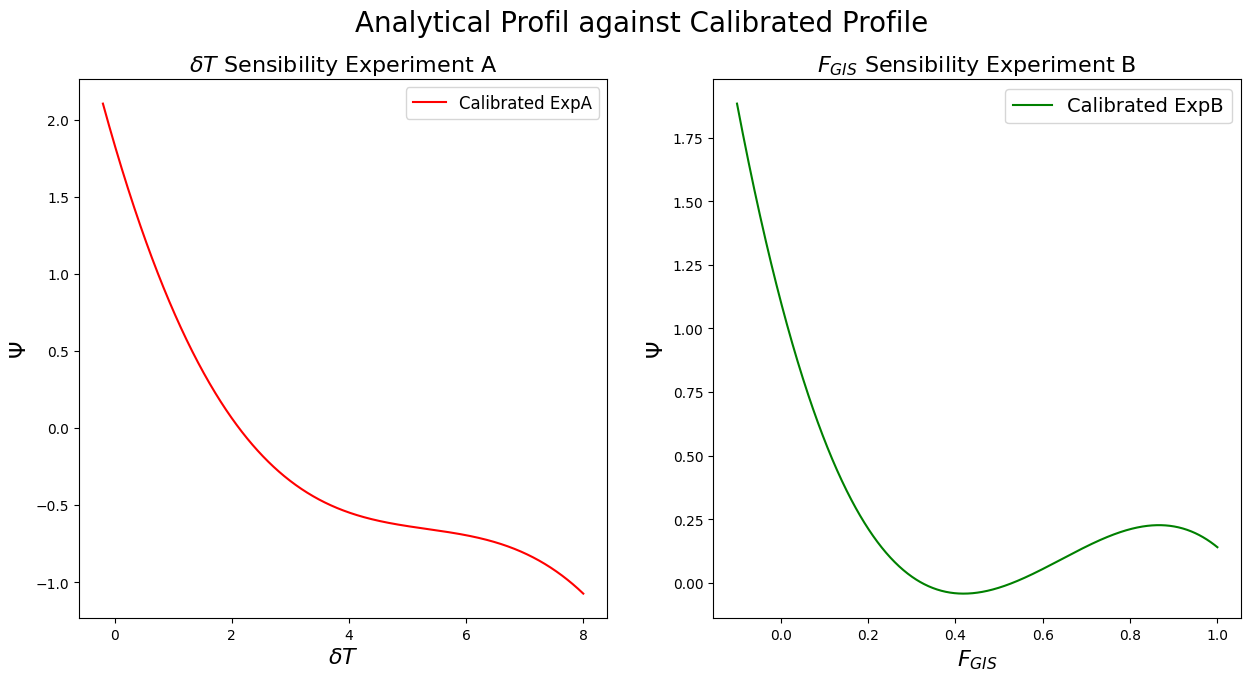

In [99]:
### Bifurcation diagrams ###

fig, ax = plt.subplots(1,2,figsize=(15,7))

# AMOC Bifurcation diagram for temperature anomaly #
ax[0].plot(T_forcing, calib_psi_ExpA, label = "Calibrated ExpA", color="r")
ax[0].set_xlabel(r"$\delta T$", fontsize = 16)
ax[0].set_ylabel(r"$\Psi$", fontsize = 16)
ax[0].set_title(r"$\delta T$"+" Sensibility Experiment A", fontsize = 16)
ax[0].legend(fontsize = 12)

# AMOC Bifurcation diagram for fresh water flux anomaly #
ax[1].plot(F_forcing, calib_psi_ExpB, label = "Calibrated ExpB", color="g")
ax[1].set_xlabel(r"$F_{GIS}$", fontsize = 16)
ax[1].set_ylabel(r"$\Psi$", fontsize = 16)
ax[1].set_title(r"$F_{GIS}$"+" Sensibility Experiment B", fontsize = 16)
ax[1].legend(fontsize = 14)

plt.suptitle("Analytical Profil against Calibrated Profile", fontsize = 20)
plt.plot()